In [31]:
# REQUIREMENT for spacy
# !python -m spacy download de_core_news_sm

In [45]:
import re
import os
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from matplotlib import cm
from wordcloud import WordCloud
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from germansentiment import SentimentModel
from gensim.models.fasttext import FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
import tensorflow as tf

sentiment_model = SentimentModel()

german_spell_check = SpellChecker(language='de')
spacy_nlp = spacy.load('de_core_news_sm') 

## Data Overview

In [46]:
df_protocols = pd.read_csv('./data/all_bundestagsprotokolle.csv')
df_protocols.head()

,speaker,party,speech,date,applause_grüne,applause_linke,applause_fdp,applause_cdu/csu,applause_spd,applause_afd,shout_grüne,shout_linke,shout_fdp,shout_cdu/csu,shout_spd,shout_afd
0,Gabriele Katzmarek,SPD,Sie ist nicht in Stein gemeißelt – das wissen ...,2021-10-26,1,0,1,1,1,0,0,0,0,0,0,0
1,Stefan Müller,CDU/CSU,"Ich sage das deswegen, weil Demokratie ja imme...",2021-10-26,4,3,4,4,4,2,0,0,0,0,0,0
2,Britta Haßelmann,BÜNDNIS 90/DIE GRÜNEN,"Liebe Kolleginnen und Kollegen, meine Damen un...",2021-10-26,8,4,5,5,6,0,0,0,0,0,0,0
3,Marco Buschmann,FDP,"Entscheidend ist aber, dass wir heute das auss...",2021-10-26,2,2,3,2,2,1,0,0,0,0,0,0
4,Stephan Brandner,AfD,"Meine Damen und Herren, lassen Sie uns kurz ü...",2021-10-26,0,1,0,0,1,9,0,0,0,0,1,0


In [47]:
df_articles_self = pd.read_csv('./data/all_articles_self.csv')
df_articles_self.head()

,title,url,summary,last_edit_date,authors,text,topic,source,tags
0,EU und China planen Verhandlungen über möglich...,https://www.zeit.de/wirtschaft/2024-06/e-autos...,Die EU hatte China mit Strafzöllen auf E-Autos...,2024-06-22 20:20:54+02:00,['Stella Männer'],China und die EU wollen im Streit über Strafzö...,E-Autos,"Quelle: ZEIT ONLINE,\n Reuters,\n ...","['China', 'EU-Kommission', 'Aktuelle Themen']"
1,Da will ich doch wohl mal hoffen,https://www.zeit.de/2024/27/ostdeutschland-lan...,"Warum es wichtig ist, auch das Gute zu sehen. ...",2024-06-22 18:14:07+02:00,[],Neulich besuchte ich Freunde in Dresden. Wir s...,Ostdeutschland,Aus der\n ZEIT Nr. 27/2024,"['Ostdeutschland', 'Alternative für Deutschlan..."
2,Medaillenvergabe an Javier Milei im Hamburg bl...,https://www.zeit.de/politik/2024-06/argentinie...,Wenige hundert Menschen haben gegen eine Ehrun...,2024-06-22 22:30:00+02:00,['Sarah Vojta'],Hunderte Menschen haben in Hamburg gegen die V...,Argentiniens Präsident,"Quelle: ZEIT ONLINE,\n dpa","['Argentinien', 'Hamburg', 'Aktuelle Themen']"
3,Belgien siegt gegen Rumänien,https://www.zeit.de/sport/2024-06/belgien-ruma...,Belgien gewinnt nach Treffern von Tielemans un...,2024-06-22 23:00:26+02:00,[],Am zweiten Spieltag der Gruppe E hat Belgien m...,"Fußball EM, Gruppe E",NaN,"['Belgien', 'Rumänien', 'Fußball', 'Aktuelle T..."
4,Portugal steht im Achtelfinale,https://www.zeit.de/sport/2024-06/tuerkei-port...,Mit einem Sieg gegen die Türkei ist Portugal G...,2024-06-22 20:48:00+02:00,['Sarah Vojta'],Am zweiten Spieltag der Gruppe F hat Portugal ...,"Fußball-EM, Gruppe F","Quelle: ZEIT ONLINE,\n dpa","['Portugal', 'Türkei', 'Cristiano Ronaldo', 'D..."


In [48]:
df_articles_news = pd.read_csv('./data/all_articles_newspaper4k.csv')
df_articles_news.head()

,title,url,summary,last_edit_date,authors,text
0,E-Autos: EU und China planen Verhandlungen übe...,https://www.zeit.de/wirtschaft/2024-06/e-autos...,Die EU hatte China mit Strafzöllen auf E-Autos...,2024-06-22 20:20:54+02:00,"['Stella Männer', 'www.zeit.de']",China und die EU wollen im Streit über Strafzö...
1,Ostdeutschland: Da will ich doch wohl mal hoffen,https://www.zeit.de/2024/27/ostdeutschland-lan...,"Die Karten, auf denen Ostdeutschland fast komp...",2024-06-22 18:14:07+02:00,"['Valerie Schönian', 'www.zeit.de']",Neulich besuchte ich Freunde in Dresden. Wir s...
2,Argentiniens Präsident: Medaillenvergabe an Ja...,https://www.zeit.de/politik/2024-06/argentinie...,Wenige hundert Menschen haben gegen eine Ehrun...,2024-06-22 22:30:00+02:00,"['Sarah Vojta', 'www.zeit.de']",Hunderte Menschen haben in Hamburg gegen die V...
3,"Fußball EM, Gruppe E : Belgien siegt gegen Rum...",https://www.zeit.de/sport/2024-06/belgien-ruma...,Belgien gewinnt nach Treffern von Tielemans un...,2024-06-22 23:00:26+02:00,"['Melina Crispin', 'www.zeit.de']",Belgien – Rumänien 2:0 (1:0)\n\nAm zweiten Spi...
4,"Fußball-EM, Gruppe F: Portugal steht im Achtel...",https://www.zeit.de/sport/2024-06/tuerkei-port...,Mit einem Sieg gegen die Türkei ist Portugal G...,2024-06-22 20:48:00+02:00,"['Sarah Vojta', 'www.zeit.de']",Türkei – Portugal 0:3 (0:2)\n\nAm zweiten Spie...


In [49]:
df_protocols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22214 entries, 0 to 22213
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   speaker           22214 non-null  object
 1   party             22213 non-null  object
 2   speech            20107 non-null  object
 3   date              22214 non-null  object
 4   applause_grüne    22214 non-null  int64 
 5   applause_linke    22214 non-null  int64 
 6   applause_fdp      22214 non-null  int64 
 7   applause_cdu/csu  22214 non-null  int64 
 8   applause_spd      22214 non-null  int64 
 9   applause_afd      22214 non-null  int64 
 10  shout_grüne       22214 non-null  int64 
 11  shout_linke       22214 non-null  int64 
 12  shout_fdp         22214 non-null  int64 
 13  shout_cdu/csu     22214 non-null  int64 
 14  shout_spd         22214 non-null  int64 
 15  shout_afd         22214 non-null  int64 
dtypes: int64(12), object(4)
memory usage: 2.7+ MB


In [50]:
df_articles_self.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           218 non-null    object
 1   url             234 non-null    object
 2   summary         231 non-null    object
 3   last_edit_date  234 non-null    object
 4   authors         234 non-null    object
 5   text            231 non-null    object
 6   topic           218 non-null    object
 7   source          136 non-null    object
 8   tags            234 non-null    object
dtypes: object(9)
memory usage: 16.6+ KB


In [51]:
df_articles_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           238 non-null    object
 1   url             238 non-null    object
 2   summary         238 non-null    object
 3   last_edit_date  238 non-null    object
 4   authors         238 non-null    object
 5   text            238 non-null    object
dtypes: object(6)
memory usage: 11.3+ KB


In [52]:
df_protocols.describe()

,applause_grüne,applause_linke,applause_fdp,applause_cdu/csu,applause_spd,applause_afd,shout_grüne,shout_linke,shout_fdp,shout_cdu/csu,shout_spd,shout_afd
count,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000,22214.000000
mean,2.738903,0.588503,2.248042,1.786216,2.792248,0.959845,0.088503,0.016386,0.040650,0.101423,0.102773,0.074683
std,3.209514,1.641145,2.949486,2.739190,3.223207,1.933181,0.436794,0.177270,0.251076,0.505251,0.509327,0.436954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,3.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136.000000,22.000000,133.000000,52.000000,136.000000,23.000000,12.000000,10.000000,6.000000,13.000000,13.000000,12.000000


## Data Cleaning

In [53]:
# merge newspaper columns into self columns where values are missing
# lowercase texts
# remove non alphabetic chars and special characters in text and html encodings e.g. &#34; for 34
# perform stop word removal
# perform lemmatization on text
# self build scraper generally scrapes articles in the standard layout better, but there are also special articles which follow another layout -> we merge these articles (newspaper4k & self merge)

In [54]:
def remove_non_alphabetic_chars(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower() # we lose information, because in german every noun is capitalized -> nevertheless can be helpful, especially with a small dataset

def correct_word(word):
    corrected = german_spell_check.correction(word)
    return corrected if corrected else word

def perform_spell_check(text):
    doc = spacy_nlp(text)
    return ' '.join([correct_word(token.text) for token in doc if not token.is_stop]) # Tokenization, Stop_Word_Removal and Spellcheck

def clean_text(text, spell_check = True):
    text = remove_non_alphabetic_chars(text)
    # after performing the spell check it can correct non stop_words to stop_words (eaine -> eine) and we need to check for stop_words again
    doc = spacy_nlp(perform_spell_check(text) if spell_check else text) 
    cleaned_text = ' '.join([token.lemma_.lower() for token in doc if not token.is_stop]) # Lemmatization: Reduce words to their base form (not root)
    return cleaned_text

def filter_list(sentences: list[str], words_to_remove: list[str]) -> list[str]:
    filtered_list = []
    for sentence in sentences:
        include_string = True
        for word in words_to_remove:
            if word in sentence:
                include_string = False
                break
        if include_string:
            filtered_list.append(sentence)

    return filtered_list

In [55]:
# clean articles
articles_cleaned_file = "./data/all_articles_cleaned.csv"
if not os.path.exists(articles_cleaned_file):
    df_articles_self.set_index('url', inplace=True)
    df_articles_news.set_index('url', inplace=True)
    
    df_articles_cleaned = df_articles_self.copy()
    df_articles_cleaned = df_articles_cleaned.dropna(subset=['text']) # missing texts -> premium article or media article
    # Fill NaN values in df_articles_cleaned with corresponding values from df_articles_news
    df_articles_cleaned['title'] = df_articles_cleaned['title'].fillna(df_articles_news['title'])
    df_articles_cleaned = df_articles_cleaned.dropna(subset=['title']) 
    df_articles_cleaned['last_edit_date'] = df_articles_cleaned['last_edit_date'].fillna(df_articles_news['last_edit_date'])
    df_articles_cleaned['summary'] = df_articles_cleaned['summary'].fillna(df_articles_news['summary'])
    df_articles_cleaned['tags'] = df_articles_cleaned['tags'].fillna("unbekannt")
    df_articles_cleaned['source'] = df_articles_cleaned['source'].fillna("unbekannt")
    df_articles_cleaned['topic'] = df_articles_cleaned['topic'].fillna("unbekannt")

    author_filter = ["zeit", "index"]
    df_articles_cleaned['authors'] = df_articles_cleaned['authors'].apply(eval)
    df_articles_cleaned['authors'] = df_articles_cleaned['authors'].apply(lambda x: filter_list(x, author_filter))

    df_articles_cleaned[['text', 'summary', 'title', 'topic']] = df_articles_cleaned[['text', 'summary', 'title', 'topic']].map(lambda x: clean_text(x, False))
    df_articles_cleaned.reset_index().to_csv(articles_cleaned_file, index=False)
    df_articles_cleaned.reset_index(inplace=True)
else:
    df_articles_cleaned = pd.read_csv(articles_cleaned_file)

In [57]:
# clean protocols
protocols_cleaned_file = "./data/all_protocols_cleaned.csv"
if not os.path.exists(protocols_cleaned_file):
    df_protocols_cleaned = df_protocols.copy()
    df_protocols_cleaned = df_protocols_cleaned.dropna(subset=['speech', 'party'])
    df_protocols_cleaned['speech'] = df_protocols_cleaned['speech'].apply(lambda x: clean_text(x, False))
    df_protocols_cleaned = df_protocols_cleaned.dropna(subset=['speech', 'party']) # clean can create new null values
    df_protocols_cleaned = df_protocols_cleaned.drop_duplicates(subset=['speech'])
    df_protocols_cleaned['party'] = df_protocols_cleaned['party'].replace('BÜNDNIS\xa090/DIE GRÜNEN', 'DIE GRÜNEN')

    # I dont need every single minister position and special categories like chancelor for predicting parties
    # Nevertheless it's interesting to include them for analysis, I will group them as Minister
    parties_to_keep = ['DIE GRÜNEN', 'FDP', 'AfD', 'SPD', 'CDU/CSU', 'DIE LINKE']
    df_protocols_cleaned['party'] = df_protocols_cleaned['party'].apply(lambda x: x if x in parties_to_keep else 'Minister')
    
    # Feature Engineering and global vars
    df_protocols_cleaned['total_applause'] = df_protocols_cleaned[[col for col in df_protocols_cleaned.columns if col.startswith('applause_')]].sum(axis=1)
    df_protocols_cleaned['speech_word_count'] = df_protocols_cleaned['speech'].str.split().apply(len)
    
    df_protocols_cleaned = df_protocols_cleaned[df_protocols_cleaned['speech_word_count'] >= 20]
    
    df_protocols_cleaned.to_csv(protocols_cleaned_file, index=False)
else:
    df_protocols_cleaned = pd.read_csv(protocols_cleaned_file)

## Data Analysis

### Parlament Analysis

In [58]:
# global styling
party_palette = {
    'SPD': '#E3000F',       # Red
    'CDU/CSU': '#4a4a4a',   # Black
    'DIE GRÜNEN': '#64A12D',# Green
    'FDP': '#FFED00',       # Yellow
    'AfD': '#009EE0',       # Blue
    'DIE LINKE': '#BE3075',  # Magenta
    'Minister': '#747a76',   # Grey
    'spd': '#E3000F',       # Red
    'cdu/csu': '#4a4a4a',   # Black
    'grüne': '#64A12D',# Green
    'fdp': '#FFED00',       # Yellow
    'afd': '#009EE0',       # Blue
    'linke': '#BE3075',  # Magenta
    'minister': '#747a76'   # Grey
}

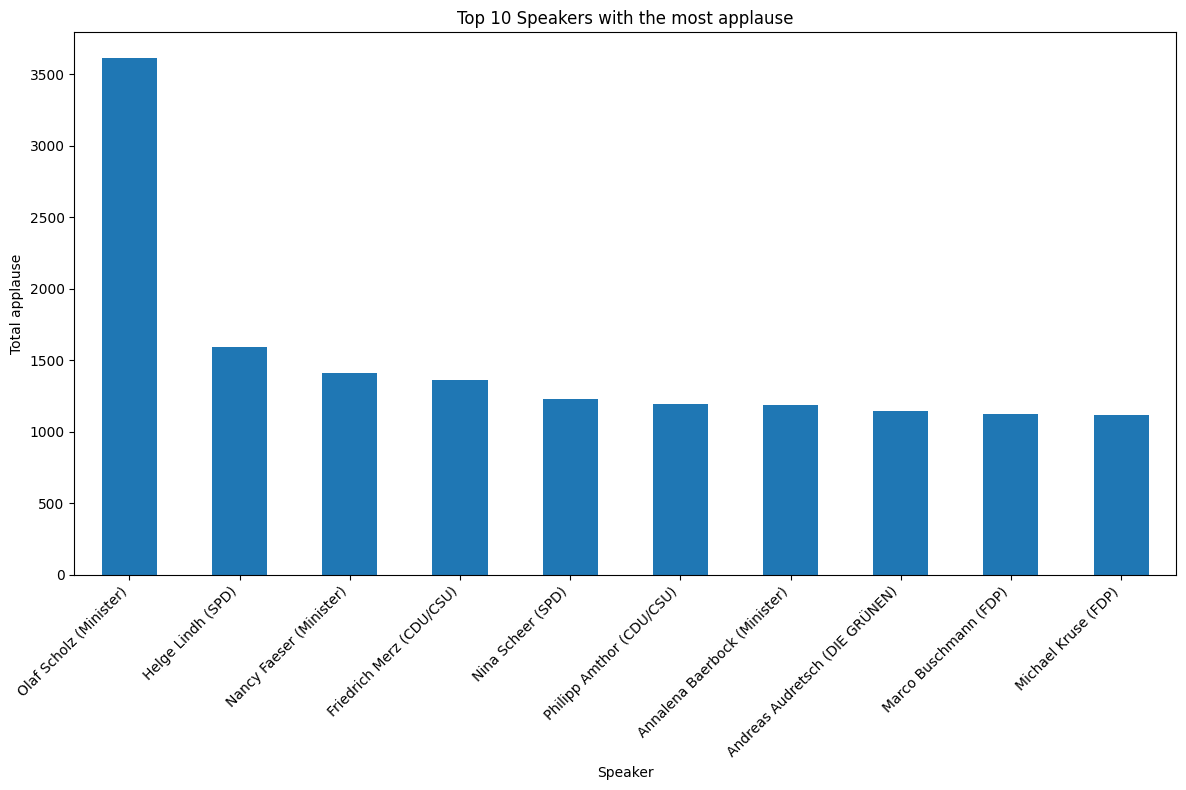

In [59]:
top_10_speakers = df_protocols_cleaned.groupby('speaker')['total_applause'].sum().sort_values(ascending=False).head(10)
top_speakers_info = df_protocols_cleaned[df_protocols_cleaned['speaker'].isin(top_10_speakers.index)].drop_duplicates(subset=['speaker'])[['speaker', 'party']]
speaker_party_mapping = top_speakers_info.set_index('speaker')['party'].to_dict()
labels = [f"{speaker} ({speaker_party_mapping[speaker]})" for speaker in top_10_speakers.index]
# Plotting
plt.figure(figsize=(12, 8))
top_10_speakers.plot(kind='bar')
plt.title('Top 10 Speakers with the most applause')
plt.xlabel('Speaker')
plt.ylabel('Total applause')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

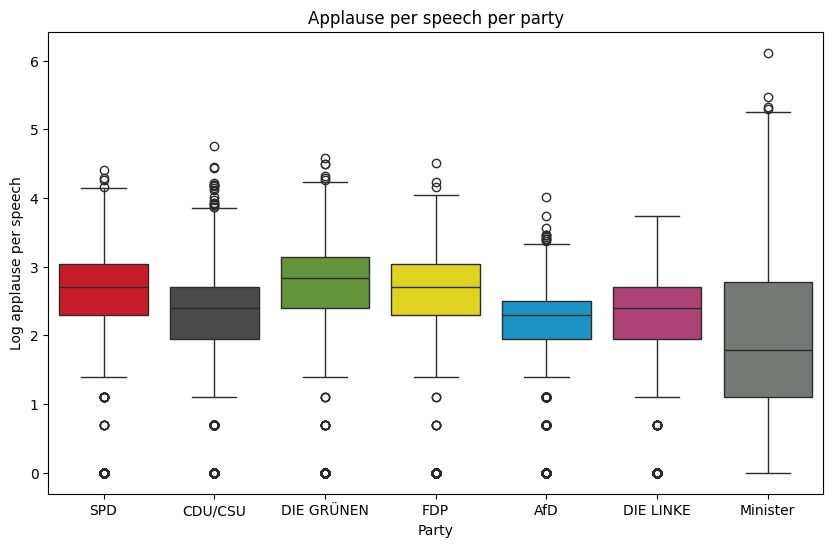

In [60]:
df_protocols_cleaned['log_total_applause'] = np.log1p(df_protocols_cleaned['total_applause'])

# Create a boxplot with the log-transformed data
plt.figure(figsize=(10, 6))
sns.boxplot(x='party', y='log_total_applause', data=df_protocols_cleaned, palette=party_palette, hue='party')
plt.title('Applause per speech per party')
plt.xlabel('Party')
plt.ylabel('Log applause per speech')
plt.show()

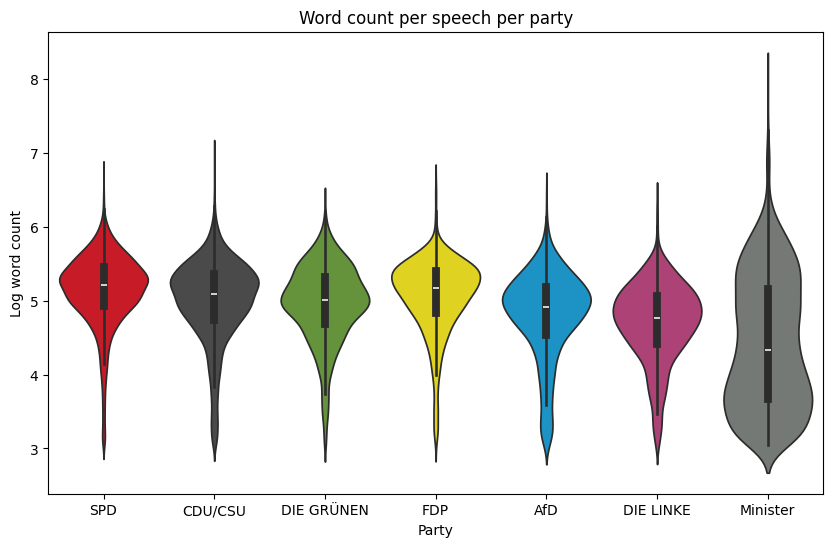

In [61]:
# Boxplot for speech word count per party
df_protocols_cleaned['log_speech_word_count'] = np.log1p(df_protocols_cleaned['speech_word_count'])

plt.figure(figsize=(10, 6))
sns.violinplot(x='party', y='log_speech_word_count', data=df_protocols_cleaned, palette=party_palette, hue='party')
plt.title('Word count per speech per party')
plt.xlabel('Party')
plt.ylabel('Log word count')
plt.show()

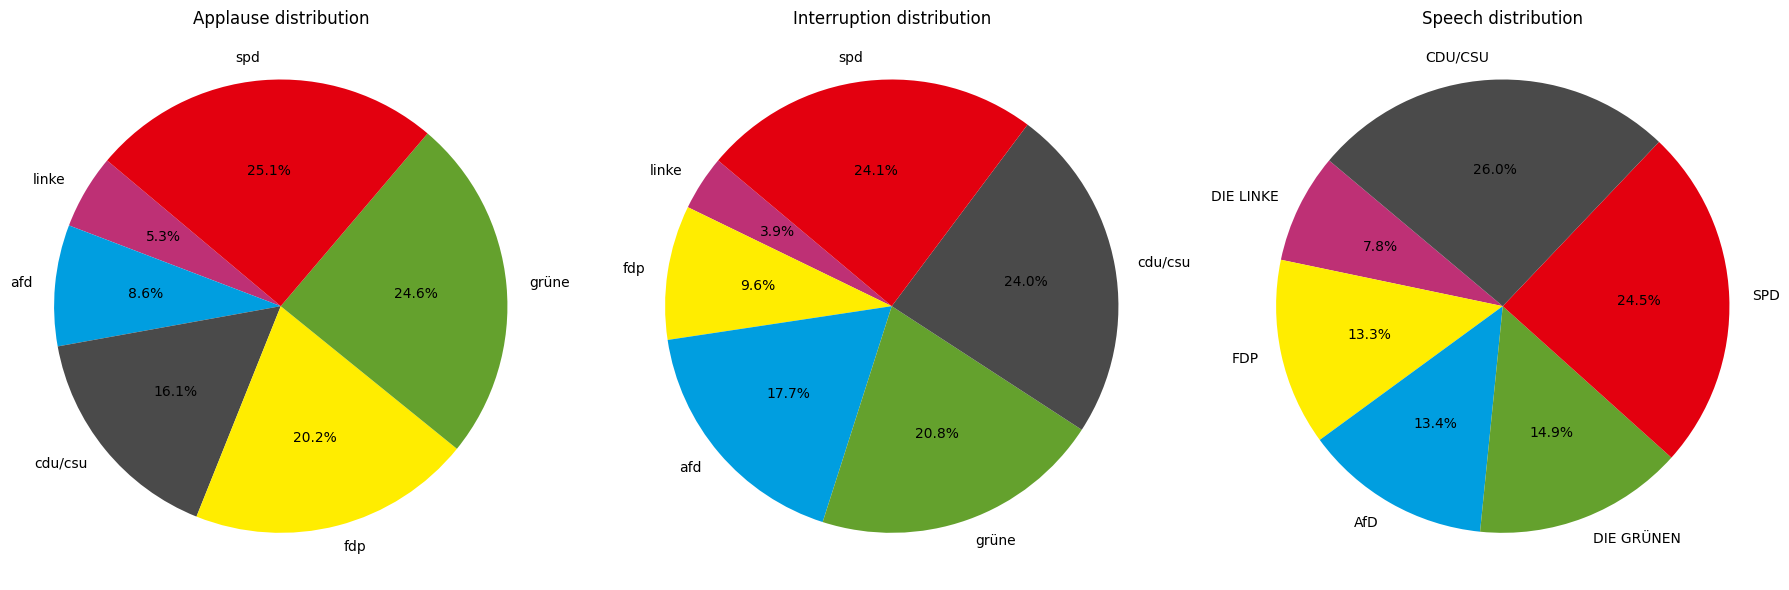

In [62]:
# Applause and interruptions among parties
# The speech distribution nearly equals seats in parlament, little bit different, because ministers are extra category and FDP, GRÜNE and SPD provide ministers
party_applause = df_protocols_cleaned[[col for col in df_protocols_cleaned.columns if col.startswith('applause_')]].sum().sort_values()
party_shouts = df_protocols_cleaned[[col for col in df_protocols_cleaned.columns if col.startswith('shout_')]].sum().sort_values()
party_speeches = df_protocols_cleaned[df_protocols_cleaned['party'] != "Minister"]['party'].value_counts().sort_values()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot pie chart for applause distribution
ax1.pie(party_applause, labels=[party.split('_')[1] for party in party_applause.index], autopct='%1.1f%%', startangle=140, colors=[party_palette[party.split('_')[1]] for party in party_applause.index])
ax1.set_title('Applause distribution')
ax1.axis('equal')

# Shout/Interruption distribution
ax2.pie(party_shouts, labels=[party.split('_')[1] for party in party_shouts.index], autopct='%1.1f%%', startangle=140, colors=[party_palette[party.split('_')[1]] for party in party_shouts.index])
ax2.set_title('Interruption distribution')
ax2.axis('equal')

# Speech distribution
ax3.pie(party_speeches, labels=party_speeches.index, autopct='%1.1f%%', startangle=140, colors=[party_palette[party] for party in party_speeches.index])
ax3.set_title('Speech distribution')
ax3.axis('equal') 

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

C:\Users\Eric User\AppData\Local\Temp\ipykernel_11172\1999166114.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_protocols_cleaned.groupby('party').apply(lambda x: x.sample(n=100, random_state=1)).reset_index(drop=True)


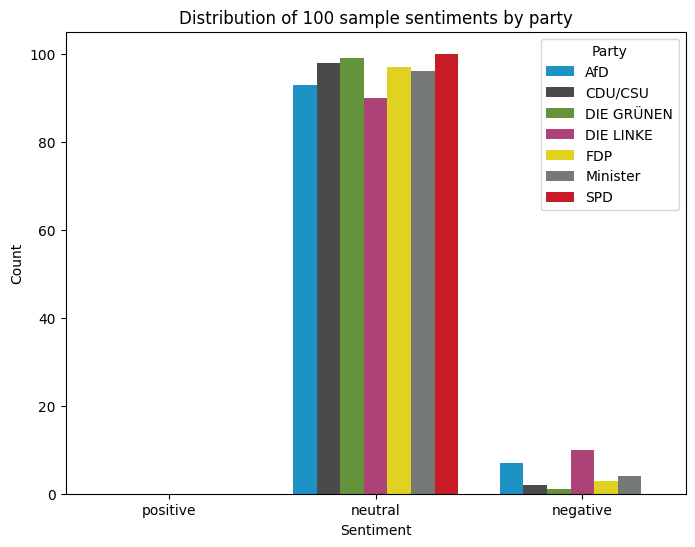

In [63]:
# Distribution of sentiments by party
df_sampled = df_protocols_cleaned.groupby('party').apply(lambda x: x.sample(n=100, random_state=1)).reset_index(drop=True)

df_sampled['sentiment'] = df_sampled['speech'].apply(lambda x: sentiment_model.predict_sentiment([x])[0])

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', hue='party', data=df_sampled, palette=party_palette, order=['positive', 'neutral', 'negative'])
plt.title('Distribution of 100 sample sentiments by party')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Party')
plt.show()

In [64]:
# To understand our result better
sentiment_model.predict_sentiment(["Wirtschaft", "Militär", "Politik", "Kanzler", "Wachstum", "Bundestag", "Gesetz"], output_probabilities=True)

(['neutral',
  'negative',
  'neutral',
  'positive',
  'positive',
  'negative',
  'negative'],
 [[['positive', 0.0013448467943817377],
   ['negative', 0.00431794160977006],
   ['neutral', 0.994337260723114]],
  [['positive', 0.04332178086042404],
   ['negative', 0.9557923674583435],
   ['neutral', 0.0008859251393005252]],
  [['positive', 0.0023081027902662754],
   ['negative', 0.006151540204882622],
   ['neutral', 0.9915403723716736]],
  [['positive', 0.5077511668205261],
   ['negative', 0.4390423893928528],
   ['neutral', 0.05320645868778229]],
  [['positive', 0.6102410554885864],
   ['negative', 0.3234676420688629],
   ['neutral', 0.06629133969545364]],
  [['positive', 0.43373680114746094],
   ['negative', 0.4343767762184143],
   ['neutral', 0.13188643753528595]],
  [['positive', 0.35809415578842163],
   ['negative', 0.613793134689331],
   ['neutral', 0.02811266854405403]]])

### Article Analysis

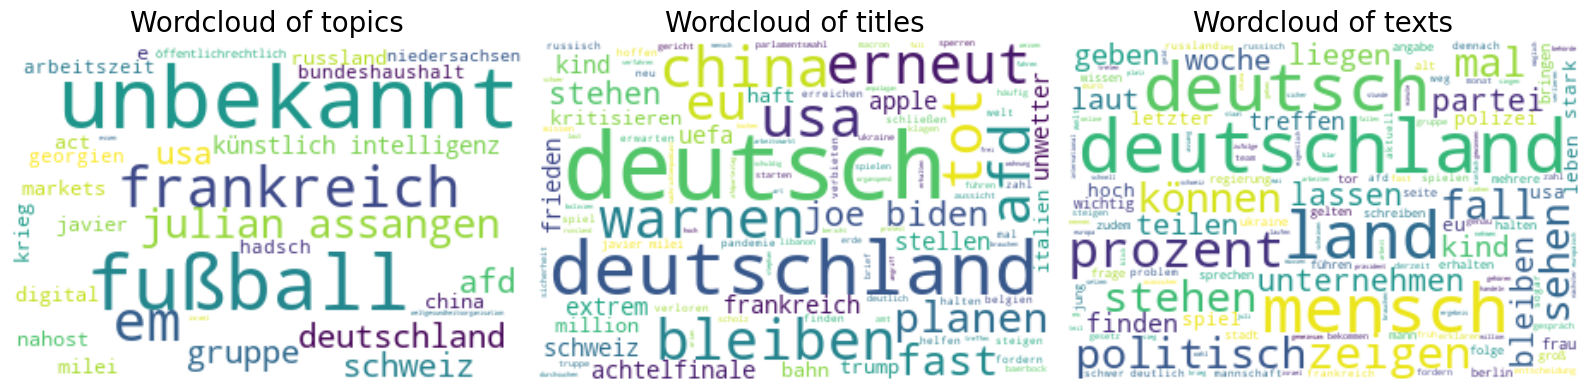

In [65]:
# Wordclouds
all_text = ' '.join(df_articles_cleaned['text'])
all_topics = ' '.join(df_articles_cleaned['topic'])
all_titles = ' '.join(df_articles_cleaned['title'])

def plot_wordcloud(ax, text, title):
    wordcloud = WordCloud(width=300, height=200, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=20)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
plot_wordcloud(axs[0], all_topics, 'Wordcloud of topics')
plot_wordcloud(axs[1], all_titles, 'Wordcloud of titles')
plot_wordcloud(axs[2], all_text, 'Wordcloud of texts')
plt.tight_layout()
plt.show()

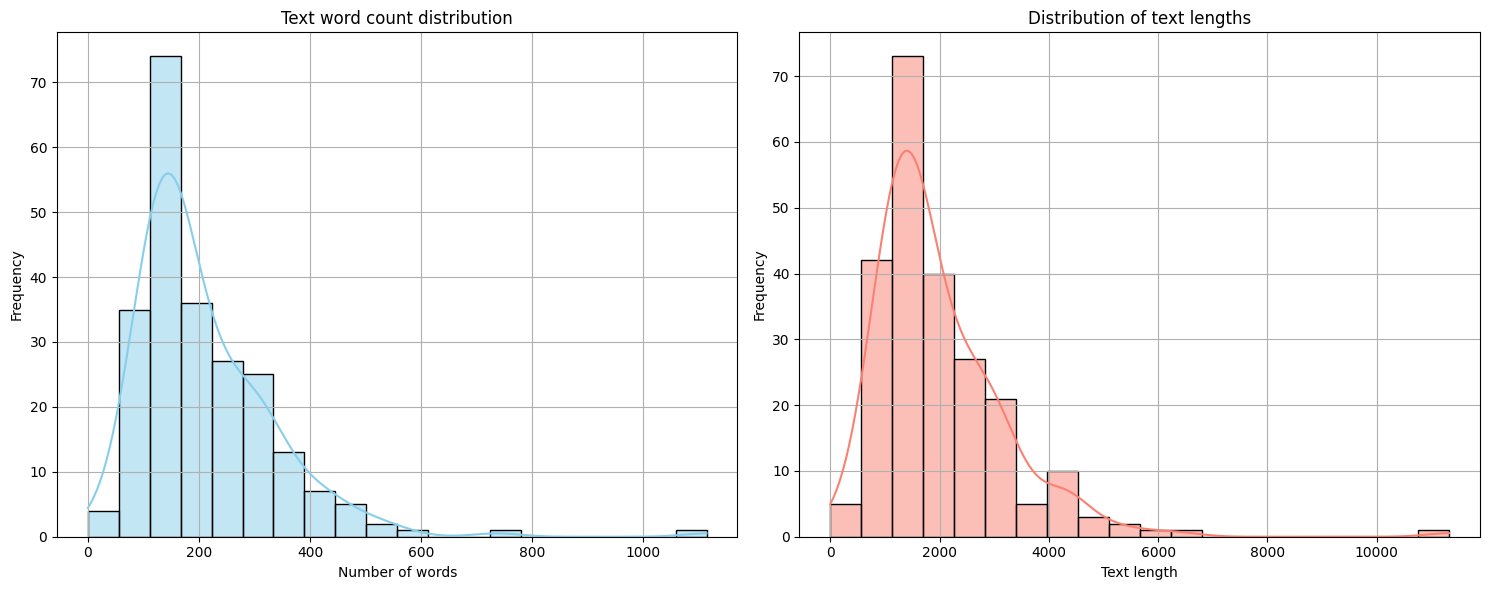

In [66]:
# Plot word count and text length distribution
df_articles_cleaned['text_word_count'] = df_articles_cleaned['text'].apply(lambda x: len(str(x).split()))
df_articles_cleaned['text_length'] = df_articles_cleaned['text'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df_articles_cleaned['text_word_count'], bins=20, kde=True, color='skyblue', ax=ax1)
ax1.set_title('Text word count distribution')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Frequency')
ax1.grid(True)

sns.histplot(df_articles_cleaned['text_length'], bins=20, kde=True, color='salmon', ax=ax2)
ax2.set_title('Distribution of text lengths')
ax2.set_xlabel('Text length')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [67]:
df_articles_cleaned[df_articles_cleaned['topic'].str.contains("w")]

,url,title,summary,last_edit_date,authors,text,topic,source,tags,text_word_count,text_length
11,https://www.zeit.de/politik/deutschland/2024-0...,städtebund erwarten asyldrittstaatenverfahren ...,asylverfahren drittstaat außerhalb eu brächn l...,2024-06-22 11:50:04+02:00,[Maline Hofmann],möglich asylverfahren drittstaat erwartung sta...,einwanderung,"Quelle: ZEIT ONLINE,\n AFP,\n dpa","['Einwanderung', 'Asyl', 'Olaf Scholz', 'Geflü...",138,1385
13,https://www.zeit.de/gesellschaft/zeitgeschehen...,zahl schwangerschaftsabbrüch zuletzt steigen,quartal mensch schwangerschaft abgebrochen mei...,2024-06-19 09:53:02+02:00,[Jona Spreter],monat jahr zahl schwangerschaftsabbrüch deutsc...,schwangerschaft,"Quelle: ZEIT ONLINE,\n AFP","['Schwangerschaftsabbruch', 'Schwangerschaft',...",88,865
14,https://www.zeit.de/gesellschaft/schule/2024-0...,erstklässlern schuljahr wiederholen,gräfenauschule pfälzisch ludwigshafen fast ers...,2024-06-19 08:46:02+02:00,[Anna-Lena Schlitt],dergräfenauschule pfälzisch ludwigshafen erneu...,ludwigshafen,"Quelle: ZEIT ONLINE,\n dpa","['Ludwigshafen', 'Schule', 'Sprache', 'Integra...",86,929
15,https://www.zeit.de/gesellschaft/zeitgeschehen...,mindestens toter waldbrände usa,usa lodern fast waldbränd bundesstaat new mexi...,2024-06-19 08:13:47+02:00,[Jona Spreter],waldbrände bundesstaat new mexico südwesten us...,new mexico,"Quelle: ZEIT ONLINE,\n dpa","['USA', 'New Mexico', 'Waldbrand', 'Hitze', 'B...",99,904
19,https://www.zeit.de/kultur/film/2024-06/chinat...,ungerechtigkeit welt,chinatown uskinos film perfekt drehbuch indes ...,2024-06-22 13:27:33+02:00,[],film chinatownam juni usamerikanisch kinos anl...,chinatown,unbekannt,"['Filmgeschichte', 'Roman Polanski', 'Jack Nic...",526,5206
22,https://www.zeit.de/wissen/umwelt/2024-06/unwe...,unwetter stören zugverkehr ostdeutschland,schwer gewitter zeitweise überschwemmungen stö...,2024-06-22 01:15:41+02:00,"[Lea-Katharina Krause, Marlena Wessollek, Leon...",deutsch wetterdienst dwd rechnen unwetter deut...,extremwetter,"Quelle: ZEIT ONLINE,\n dpa,\n AFP","['Ostdeutschland', 'Fanmeile', 'Gewitter', 'Un...",148,1432
23,https://www.zeit.de/wissen/umwelt/2024-06/usa-...,temperaturen usa erreichen grad,großstadt phoenix bislang hoch temperatur jahr...,2024-06-22 00:48:31+02:00,[Isabelle Daniel],gefährlich hitzewelle teil usa dauern großstad...,hitzewelle usa,"Quelle: ZEIT ONLINE,\n AP","['USA', 'Hitzewelle', 'Arizona', 'New Mexico',...",124,1150
26,https://www.zeit.de/2024/27/weltyogatag-indien...,ausdehnung,lifestylesport ersatzreligion indisch traditio...,2024-06-21 12:32:22+02:00,[],juni weltyogatag erfinden heutig lifestylespor...,weltyogatag,Aus der\n ZEIT Nr. 27/2024,"['Yoga', 'Entspannung', 'Freizeit', 'Indien', ...",45,470
27,https://www.zeit.de/digital/datenschutz/2024-0...,usa kasperskysoftwar verbannen,usa antivirensoftware russisch firma kaspersky...,2024-06-21 13:49:32+02:00,[],usa antivirensoftwar kaspersky verbiet grund s...,kasperskysoftware,unbekannt,"['USA', 'Russland', 'Software', 'Computer', 'I...",311,3180
28,https://www.zeit.de/politik/ausland/2024-06/us...,usa verbieten russisch antivirenprogramm kaspe...,russisch software kaspersky pcs vir schütze us...,2024-06-21 04:57:02+02:00,[Isabelle Daniel],usregierung verbieten russisch virenschutzsoft...,russisch antivirensoftwar,"Quelle: ZEIT ONLINE,\n dpa,\n AFP","['US-Regierung', 'USA', 'IT-Sicherheit', 'Soft...",143,1380


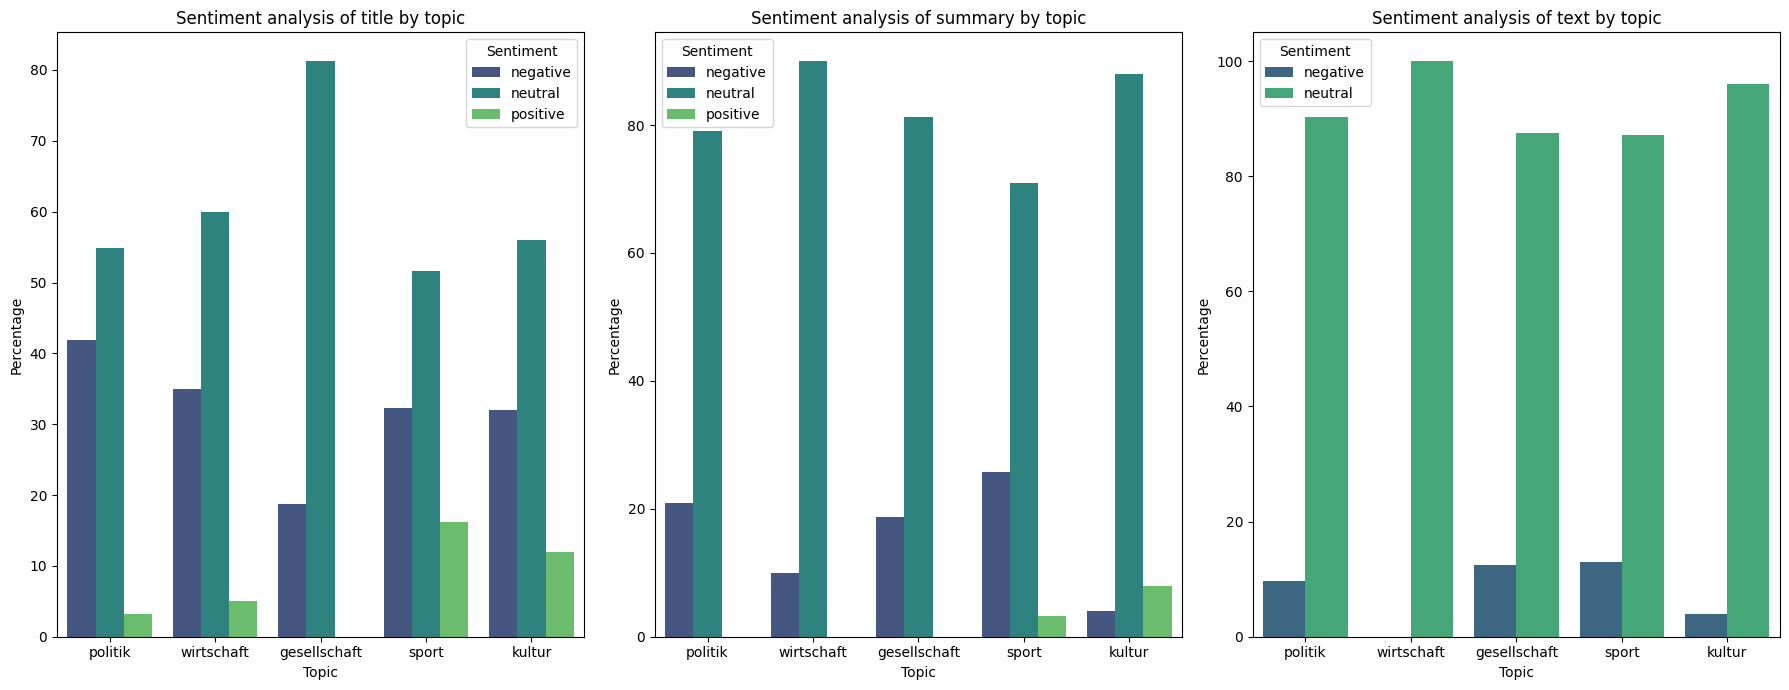

In [68]:
def map_url_to_topic(topics: list[str], url: str):
    for topic in topics:
        if topic in url:
            return topic
            
    return None

def create_sentiment_plot(ax, topics: list[str], df: pd.DataFrame, column_name: str):
    df['sentiment'] = df[column_name].apply(lambda x: sentiment_model.predict_sentiment([x])[0])
    sentiment_counts = df.groupby(['type', 'sentiment']).size().reset_index(name='count')
    total_counts = df.groupby('type').size().reset_index(name='total')
    sentiment_percentage = pd.merge(sentiment_counts, total_counts, on='type')
    sentiment_percentage['percentage'] = sentiment_percentage['count'] / sentiment_percentage['total'] * 100
    sns.barplot(x='type', y='percentage', hue='sentiment', data=sentiment_percentage, palette='viridis', order=topics, ax=ax)
    ax.set_title(f'Sentiment analysis of {column_name} by topic')
    ax.set_xlabel('Topic')
    ax.set_ylabel('Percentage')
    ax.legend(title='Sentiment')
    
    
topics = ['politik', 'wirtschaft', 'gesellschaft', 'sport', 'kultur']
df_filtered = df_articles_cleaned.copy()
df_filtered['type'] = df_filtered['url'].apply(lambda x : map_url_to_topic(topics, x))
df_filtered = df_filtered.dropna(subset=['type'])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
create_sentiment_plot(ax1, topics, df_filtered, 'title')
create_sentiment_plot(ax2, topics, df_filtered, 'summary')
create_sentiment_plot(ax3, topics, df_filtered, 'text')

plt.tight_layout()
plt.show()

# Models

### Predict Claps
- Claps are like a sentiments but without getting it from words and context

In [71]:
# cut everything outside the 95% interval, because these arent real speeches and more like small or big Q&As
q025_applause = np.percentile(df_protocols_cleaned['total_applause'], 2.5)
q975_applause = np.percentile(df_protocols_cleaned['total_applause'], 97.5)
df_protocols_filtered = df_protocols_cleaned[(df_protocols_cleaned['total_applause'] >= q025_applause) & (df_protocols_cleaned['total_applause'] <= q975_applause)]

In [72]:
X = df_protocols_filtered['speech']
y = df_protocols_filtered['total_applause']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1000)),
    ('regressor', LinearRegression())
])

param_grid = [
    {
        'regressor': [LinearRegression()]
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [10, 20]
    },
    {
        'regressor': [GradientBoostingRegressor()],
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.1, 0.15]
    },
    {
        'regressor': [MLPRegressor(max_iter=1000)],
        'regressor__hidden_layer_sizes': [(100,50), (50, 50), (100,50,25,5)],
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=1000)),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'regressor': [LinearRegression()]},
                         {'regressor': [RandomForestRegressor()],
                          'regressor__max_depth': [10, 20],
                          'regressor__n_estimators': [50, 100]},
                         {'regressor': [GradientBoostingRegressor()],
                          'regressor__learning_rate': [0.1, 0.15],
                          'regressor__n_estimators': [100, 200]},
                         {'regressor': [MLPRegressor(max_iter=1000)],
                          'regressor__hidden_layer_sizes': [(100, 50), (50, 50),
                                                            (100, 50, 25, 5)]}],
             scoring='neg_mean_absolute_error')

In [76]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Best Parameters: {'regressor': GradientBoostingRegressor(), 'regressor__learning_rate': 0.15, 'regressor__n_estimators': 200}
Mean Squared Error: 42.30971273913859
Mean Absolute Error: 5.12280510702611


In [77]:
predicted_applause = best_model.predict(df_articles_cleaned['text'])
mean_applause = df_protocols_filtered['total_applause'].mean()
max_applause = df_protocols_filtered['total_applause'].max()
predicted_percentage = (predicted_applause / max_applause) * 100

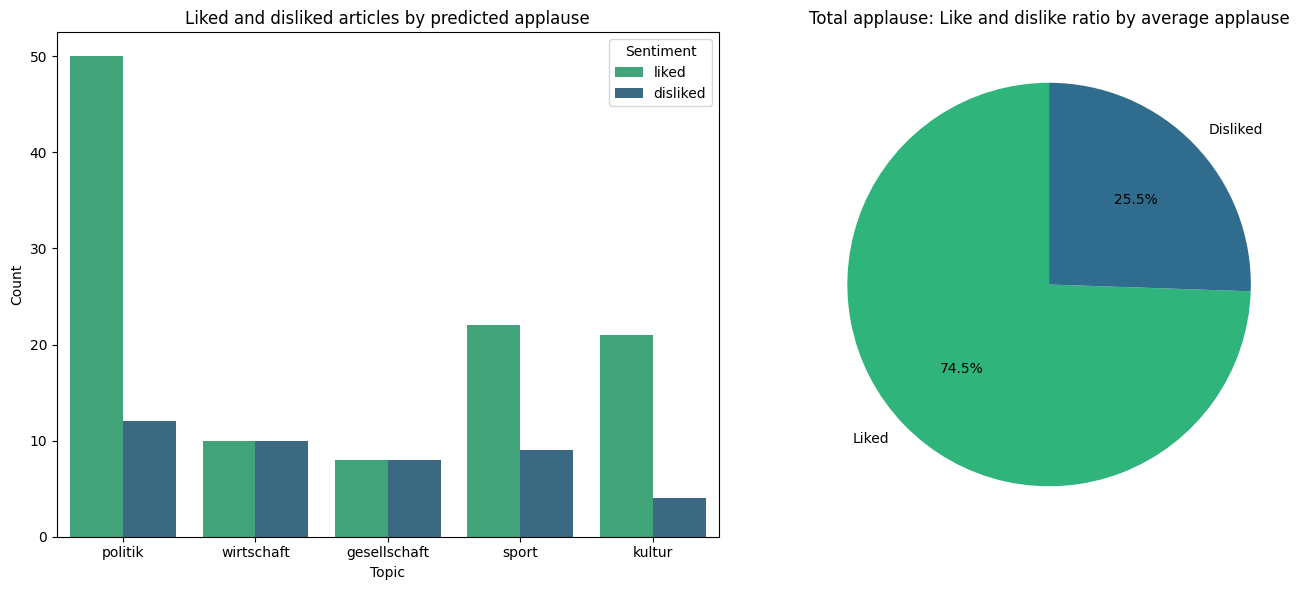

In [91]:
# Like by applause 
df_articles_copy = df_articles_cleaned.copy()

df_articles_copy['predicted_percentage'] = predicted_percentage
df_articles_copy['liked'] = df_articles_copy['predicted_percentage'].apply(lambda x: 'liked' if x >= mean_applause else 'disliked')

topics = ['politik', 'wirtschaft', 'gesellschaft', 'sport', 'kultur']
df_articles_copy['type'] = df_articles_copy['url'].apply(lambda x: map_url_to_topic(topics, x))
df_articles_copy = df_articles_copy.dropna(subset=['type'])


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='type', hue='liked', data=df_articles_copy, palette=[to_hex(cm.viridis(0.65)), to_hex(cm.viridis(0.35))] , order=topics)
plt.title('Liked and disliked articles by predicted applause')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.legend(title='Sentiment')

df_protocols_filtered.loc[:, 'liked'] = df_protocols_filtered['total_applause'].apply(lambda x: 'liked' if x >= mean_applause else 'disliked')
liked_applause = df_protocols_filtered[df_protocols_filtered['liked'] == 'liked']['total_applause'].sum()
disliked_applause = df_protocols_filtered[df_protocols_filtered['liked'] == 'disliked']['total_applause'].sum()

plt.subplot(1, 2, 2)
plt.pie([liked_applause, disliked_applause], labels=['Liked', 'Disliked'], colors=[to_hex(cm.viridis(0.65)), to_hex(cm.viridis(0.35))] , autopct='%1.1f%%', startangle=90)
plt.title('Total applause: Like and dislike ratio by average applause')

plt.tight_layout()
plt.show()

In [92]:
df_articles_copy[(df_articles_copy['liked'] == 'liked') & (df_articles_copy['type'] == 'wirtschaft')].head(1)['url'].values

array(['https://www.zeit.de/wirtschaft/2024-06/e-autos-eu-china-verhandlungen-strafzoelle'],
      dtype=object)

In [93]:
df_articles_copy[(df_articles_copy['liked'] == 'disliked') & (df_articles_copy['type'] == 'wirtschaft')].head(1)['url'].values

array(['https://www.zeit.de/wirtschaft/2024-06/handelsstreit-china-eu-robert-habeck-industrie'],
      dtype=object)

### Party Classification
- get party of newspaper articles to find political bias

In [106]:
# cut everything outside the 95% interval, because these arent real speeches and more like small or big Q&As
q025_applause = np.percentile(df_protocols_cleaned['total_applause'], 2.5)
q975_applause = np.percentile(df_protocols_cleaned['total_applause'], 97.5)
df_protocols_filtered = df_protocols_cleaned[(df_protocols_cleaned['total_applause'] >= q025_applause) & 
                                             (df_protocols_cleaned['total_applause'] <= q975_applause) & 
                                             (df_protocols_cleaned['party'] != "Minister")]

#### Basic Models

In [ ]:
X = df_protocols_filtered['speech']
y = df_protocols_filtered['party']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=2024)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# balance dataset
smote = SMOTE(random_state=2024)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [ ]:
pipeline = Pipeline([
    ('classifier', LogisticRegression())
])

param_grid = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 150],
        'classifier__max_depth': [10, 30]
    },
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1.0]
    },
    {
        'classifier': [SGDClassifier()],
        'classifier__loss': ['log_loss', 'modified_huber']
    },
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1, 1.0]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.1, 0.15]
    }
]

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


KeyboardInterrupt: 

In [ ]:
# Predict on the test set
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_tfidf)
y_pred_proba = best_model.predict_proba(X_test_tfidf)

y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

print(classification_report(y_test_decoded, y_pred_decoded, zero_division=0))

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC AUC score: {roc_auc:.2f}")

Best Parameters: {'classifier': MultinomialNB(), 'classifier__alpha': 0.1}
              precision    recall  f1-score   support

         AfD       0.88      0.48      0.62        29
     CDU/CSU       0.47      0.76      0.58        49
  DIE GRÜNEN       0.44      0.25      0.32        28
   DIE LINKE       0.00      0.00      0.00        17
         FDP       0.35      0.24      0.29        25
         SPD       0.38      0.52      0.44        52

    accuracy                           0.46       200
   macro avg       0.42      0.37      0.37       200
weighted avg       0.45      0.46      0.43       200

ROC AUC score: 0.76


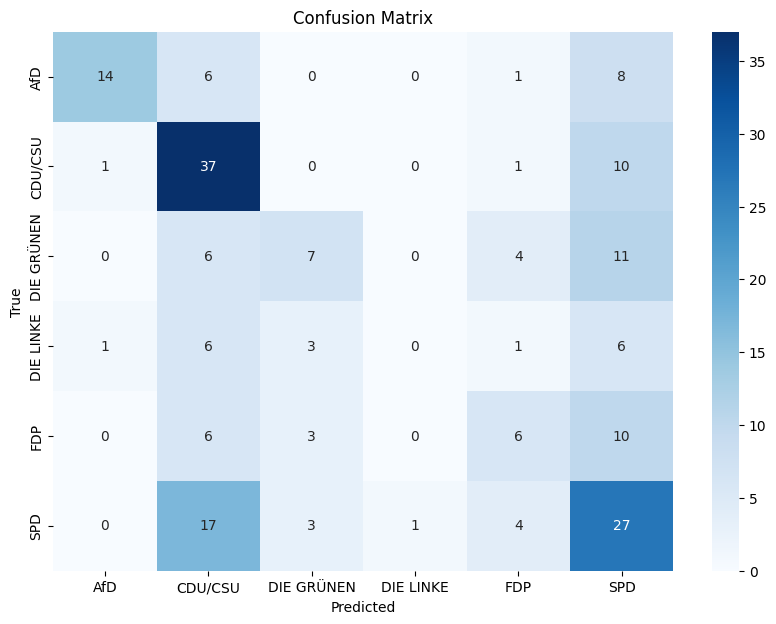

In [ ]:
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

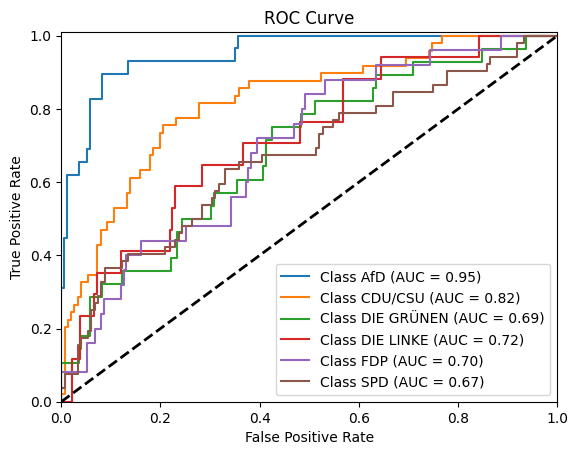

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### Fasttext and GRU

In [108]:
max_len=1000
fasttext_model = FastText(df_protocols_filtered['speech'].str.split().tolist(), vector_size=100, window=5, min_count=1, workers=6, sg=1)
embedding_matrix = fasttext_model.wv.vectors

In [109]:
print("Wirtschaft most similar:\n", fasttext_model.wv.most_similar('wirtschaft', topn=10))
print("Wirtschaft/Arbeitslosigkeit fasttext similarity: ", fasttext_model.wv.similarity('wirtschaft', 'arbeitslosigkeit'))
print("Embedding matrix shape (Vocab length, Dimensions):", embedding_matrix.shape)

Wirtschaft most similar:
 [('almwirtschaft', 0.9788742065429688), ('klubwirtschaft', 0.9762563705444336), ('wegwirtschaft', 0.9751032590866089), ('viehwirtschaft', 0.97272127866745), ('uswirtschaft', 0.9721178412437439), ('filmwirtschaft', 0.9685955047607422), ('brauwirtschaft', 0.9676870107650757), ('wirtschafn', 0.9656227827072144), ('itwirtschaft', 0.963304340839386), ('realwirtschaft', 0.9617020487785339)]
Wirtschaft/Arbeitslosigkeit fasttext similarity:  0.39509863
Embedding matrix shape (Vocab length, Dimensions): (135520, 100)


In [111]:
texts = df_protocols_filtered['speech']
vocab_size = embedding_matrix.shape[0]
one_hot_texts = [one_hot(text,vocab_size) for text in texts]
df_protocols_filtered['one_hot_text'] = one_hot_texts
embedded_doc = pad_sequences(df_protocols_filtered['one_hot_text'],padding='pre',maxlen=max_len) # transforms one_hot matrix to n*n

X = np.array(embedded_doc)
label_encoder = LabelEncoder()
y = np.array(label_encoder.fit_transform(df_protocols_filtered['party']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

smote = SMOTE(random_state=2024)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

C:\Users\Eric User\AppData\Local\Temp\ipykernel_11172\475487941.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protocols_filtered['one_hot_text'] = one_hot_texts


In [116]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(GRU(units=128, activation="tanh"))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) # USE AUC here
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │    13,552,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,552,000 (51.70 MB)

 Trainable params: 13,552,000 (51.70 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
history = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
 48/630 ━━━━━━━━━━━━━━━━━━━━ 4:00 413ms/step - accuracy: 0.1519 - loss: 1.8411

KeyboardInterrupt: 

In [124]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test)

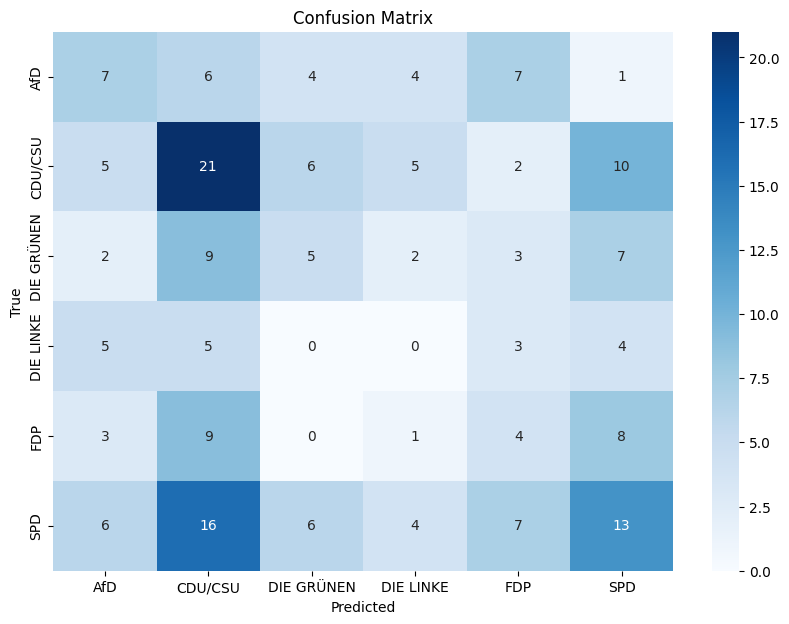

In [125]:
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

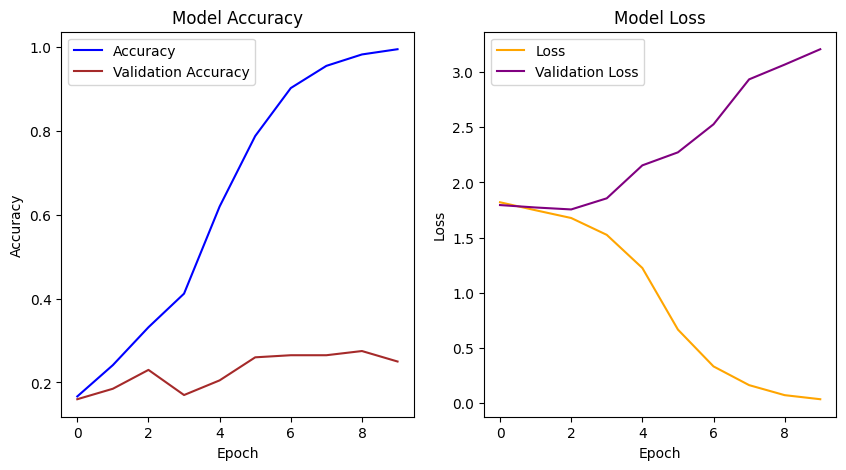

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# First subplot
ax[0].plot(history.history['accuracy'],label="Accuracy",color="blue")
ax[0].plot(history.history['val_accuracy'],label="Validation Accuracy",color="brown")
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='best')

# Second subplot
ax[1].plot(history.history['loss'],label="Loss",color="orange")
ax[1].plot(history.history['val_loss'],label="Validation Loss",color="purple")
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='best')

plt.show()